In [168]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [169]:
data = pd.read_csv('stock_data.csv')
data = data.iloc[:262, :]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,5.398742,5.427103,5.368389,5.392273,141556000,0.0,0.0
1,5.389280,5.402725,4.988682,5.282470,1527812000,0.0,0.0
2,5.259566,5.700996,5.250852,5.576758,1561116000,0.0,0.0
3,5.624310,5.985073,5.596176,5.959678,2034124000,0.0,0.0
4,5.988310,6.020428,5.871044,5.897435,931420000,0.0,0.0
...,...,...,...,...,...,...,...
257,143.000000,143.139999,132.110001,135.399994,987765800,0.0,0.0
258,137.210007,149.770004,135.570007,147.630005,973098600,0.0,0.0
259,148.679993,149.649994,140.080002,141.979996,1017459800,0.0,0.0
260,139.500000,152.889999,137.149994,141.949997,1396925400,0.0,0.0


In [170]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

def fourier_denoise(data, threshold=0.1):
    """
    Denoise time-series data using Fourier Transform.
    Args:
        data (np.array): Original time-series data.
        threshold (float): Fraction of coefficients to retain (low frequencies).
    Returns:
        np.array: Denoised time-series data.
    """
    fft_coeffs = np.fft.fft(data, axis=0)
    magnitude = np.abs(fft_coeffs)
    power_threshold = threshold * np.max(magnitude)
    fft_coeffs[magnitude < power_threshold] = 0  # Zero out low-magnitude coefficients
    denoised_data = np.fft.ifft(fft_coeffs, axis=0).real  # Keep only the real part
    return denoised_data

train_x_denoised = fourier_denoise(train_x)
test_x_denoised = fourier_denoise(test_x)

# Rescale after Fourier Denoising to ensure values are in [0, 1]
train_x_denoised = x_scaler.fit_transform(train_x_denoised)
test_x_denoised = x_scaler.transform(test_x_denoised)

trainX: (209, 7) trainY: (209,)
testX: (53, 7) testY: (53,)


In [171]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [172]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x_denoised).float()), batch_size=128, shuffle=False)
# first one must be the number of columns
model = VAE([7, 400, 400, 400, 10], 10)

[1/300] Loss: 51.30202674865723
[2/300] Loss: 51.00461196899414
[3/300] Loss: 50.79315376281738
[4/300] Loss: 50.621809005737305
[5/300] Loss: 50.45123863220215
[6/300] Loss: 50.27745246887207
[7/300] Loss: 50.101118087768555
[8/300] Loss: 49.926828384399414
[9/300] Loss: 49.75268745422363
[10/300] Loss: 49.585554122924805
[11/300] Loss: 49.427024841308594
[12/300] Loss: 49.27847862243652
[13/300] Loss: 49.14689064025879
[14/300] Loss: 49.02366638183594
[15/300] Loss: 48.922935485839844
[16/300] Loss: 48.83560371398926
[17/300] Loss: 48.763601303100586
[18/300] Loss: 48.70450019836426
[19/300] Loss: 48.65375900268555
[20/300] Loss: 48.61712455749512
[21/300] Loss: 48.58360290527344
[22/300] Loss: 48.55180358886719
[23/300] Loss: 48.523658752441406
[24/300] Loss: 48.48124694824219
[25/300] Loss: 48.43831253051758
[26/300] Loss: 48.37386512756348
[27/300] Loss: 48.293304443359375
[28/300] Loss: 48.20659255981445
[29/300] Loss: 48.10026931762695
[30/300] Loss: 47.98504638671875
[31/300] L

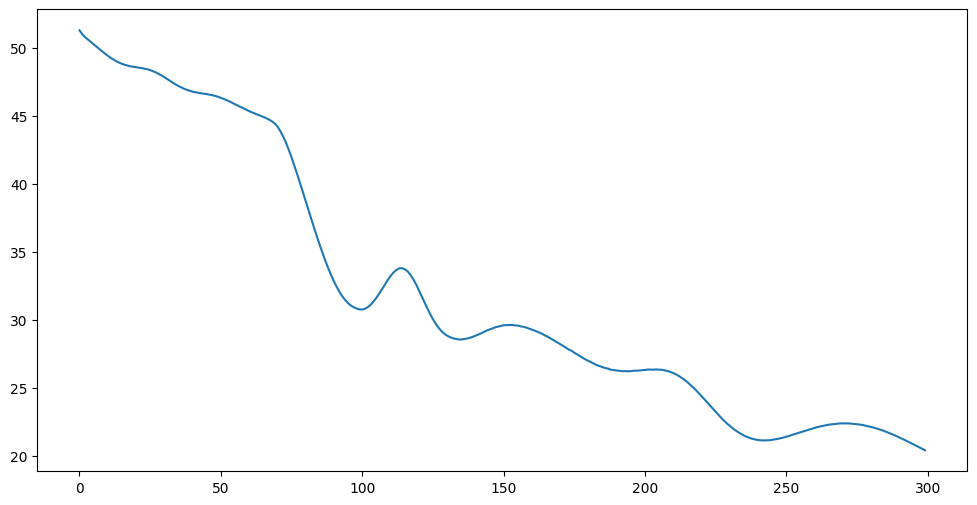

In [173]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [174]:
model.eval()
_, VAE_train_x, _, _ = model(torch.from_numpy(train_x_denoised).float().to(device))
_, VAE_test_x, _, _ = model(torch.from_numpy(test_x_denoised).float().to(device))

In [175]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [176]:
train_x_combined = np.concatenate((train_x_denoised, VAE_train_x.cpu().detach().numpy()), axis=1)
test_x_combined = np.concatenate((test_x_denoised, VAE_test_x.cpu().detach().numpy()), axis=1)

In [177]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x_combined, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x_combined, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([206, 3, 17]) train_y: torch.Size([206, 1]) train_y_gan: torch.Size([206, 4, 1])
test_x: torch.Size([50, 3, 17]) test_y: torch.Size([50, 1]) test_y_gan: torch.Size([50, 4, 1])


In [178]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        h0, c0 = (torch.zeros(1, x.size(0), 1024).to(device), torch.zeros(1, x.size(0), 1024).to(device))
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)

        h1, c1 = (torch.zeros(1, x.size(0), 512).to(device), torch.zeros(1, x.size(0), 512).to(device))
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)

        h2, c2 = (torch.zeros(1, x.size(0), 256).to(device), torch.zeros(1, x.size(0), 256).to(device))
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.linear1 = nn.Linear(hidden_size, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(device)
        rnn_out, _ = self.rnn(x, h0)
        out = rnn_out[:, -1, :]  # Get the last time step
        out_1 = self.linear1(out)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out


In [179]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

# 17 comes from train_x: torch.Size([206, 3, 17]) train_y: torch.Size([206, 1]) train_y_gan: torch.Size([206, 4, 1])
modelG = Generator(17).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 2.7727752923965454 LossG:1.3616333603858948
[2/165] LossD: 2.771814227104187 LossG:1.3650360107421875
[3/165] LossD: 2.7710230350494385 LossG:1.3682922720909119
[4/165] LossD: 2.7706973552703857 LossG:1.3714597821235657
[5/165] LossD: 2.770741581916809 LossG:1.3741315603256226
[6/165] LossD: 2.771372079849243 LossG:1.376388669013977
[7/165] LossD: 2.772747755050659 LossG:1.3786532282829285
[8/165] LossD: 2.7748626470565796 LossG:1.380694031715393
[9/165] LossD: 2.7758469581604004 LossG:1.3834717869758606
[10/165] LossD: 2.772889018058777 LossG:1.3883755803108215
[11/165] LossD: 2.7703933715820312 LossG:1.3907140493392944
[12/165] LossD: 2.770720601081848 LossG:1.3900465965270996


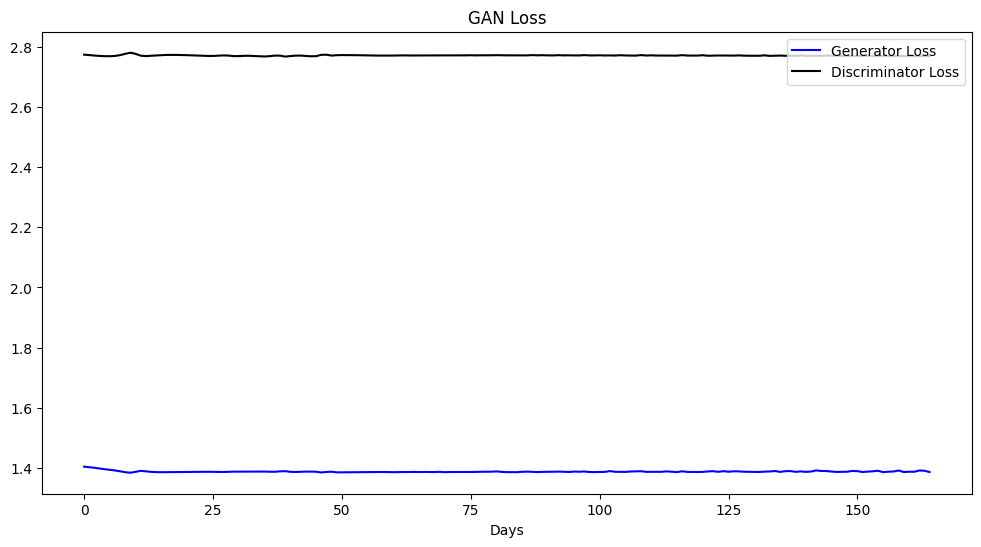

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:5.670496137870586


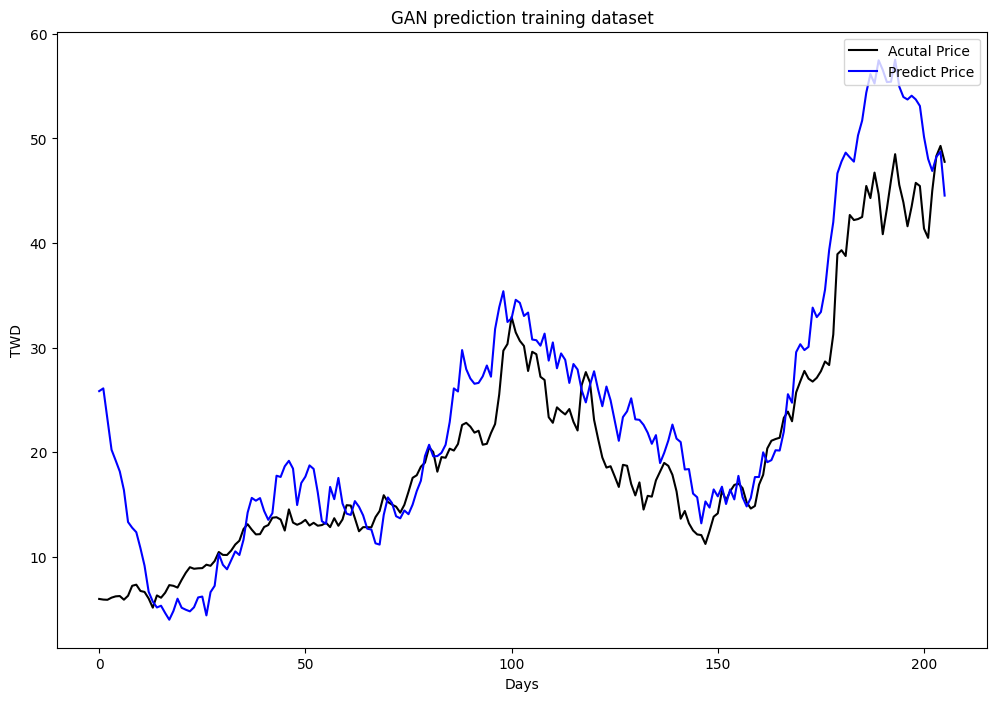

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:21.371747375176206


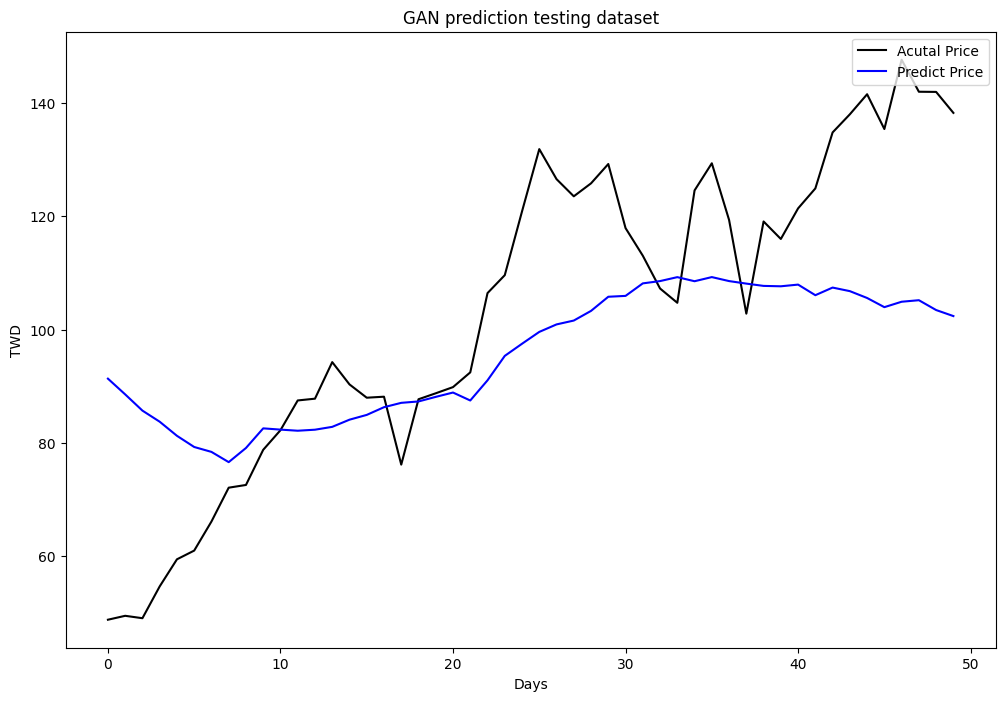

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')